In [73]:
# 📦 1. Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [74]:
# 📁 2. Load the Excel file
df = pd.read_excel("DHL_Delivery_Data_Cleaned.xlsx")

In [75]:
# 🧹 3. Strip whitespace from all column names
df.columns = df.columns.str.strip()

In [76]:
# 🕐 4. Parse time-related fields (even if only 'Delivery Time Window' is present)
if "Time Window Start" not in df.columns or "Time Window End" not in df.columns:
    time_split = df["Delivery Time Window"].str.strip().str.split(r"\s*-\s*", expand=True)
    df["Time Window Start"] = time_split[0]
    df["Time Window End"] = time_split[1]

In [77]:
# Convert time columns to datetime
time_cols = ["Actual Delivery Time", "Time Window Start", "Time Window End"]
for col in time_cols:
    df[col] = pd.to_datetime(df[col], format="%H:%M:%S", errors="coerce").fillna(
        pd.to_datetime(df[col], format="%H:%M", errors="coerce")
    )

In [78]:
# 🕓 5. Feature Engineering
df["Delay Duration"] = (df["Actual Delivery Time"] - df["Time Window End"]).dt.total_seconds() / 60
df["Delay Duration"] = df["Delay Duration"].clip(lower=0)

df["Delivery Hour"] = df["Actual Delivery Time"].dt.hour

In [79]:
# Categorical time-of-day bucket
df["Day Part"] = pd.cut(
    df["Delivery Hour"],
    bins=[-1, 11, 16, 23],
    labels=["Morning", "Afternoon", "Evening"]
)

In [80]:
# 🌦️ 6. Encode Weather and Traffic if not already numeric
if "Weather Code" not in df.columns and "Weather Condition" in df.columns:
    weather_map = {"Clear": 1, "Cloudy": 2, "Rainy": 3, "Foggy": 4, "Snowy": 5, "Windy": 6}
    df["Weather Code"] = df["Weather Condition"].map(weather_map).fillna(0).astype(int)

if "Traffic Code" not in df.columns and "Traffic Level" in df.columns:
    traffic_map = {"Low": 1, "Medium": 2, "High": 3}
    df["Traffic Code"] = df["Traffic Level"].map(traffic_map).fillna(0).astype(int)

In [81]:
# 📊 7. Create rolling averages if not present
if "Rolling Distance Avg" not in df.columns:
    df["Rolling Distance Avg"] = df["Distance (KM)"].rolling(window=3, min_periods=1).mean()

if "Rolling Delivery Hour" not in df.columns:
    df["Rolling Delivery Hour"] = df["Delivery Hour"].rolling(window=3, min_periods=1).mean()

In [82]:
# 🔥 8. Risk Score (simple version)
if "Risk Score" not in df.columns:
    df["Risk Score"] = (
        0.2 * df["Distance (KM)"].rank(pct=True) * 100 +
        0.4 * df["Traffic Code"].rank(pct=True) * 100 +
        0.4 * df["Weather Code"].rank(pct=True) * 100
    ).round(0).astype(int)

In [83]:
# 🧠 9. One-hot encode applicable categories (only if present)
categorical_cols = [col for col in ["Day Part", "Vehicle Type"] if col in df.columns]
if categorical_cols:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [84]:
# ✅ 10. Prepare features and target
BASE_FEATURES = [
    "Distance (KM)", "Package Volume (kg)", "Delivery Hour",
    "Weather Code", "Traffic Code", "Rolling Distance Avg",
    "Rolling Delivery Hour", "Risk Score"
]
EXTRA_FEATURES = [col for col in df.columns if col.startswith(("Day Part_", "Vehicle Type_"))]

feature_columns = [col for col in BASE_FEATURES if col in df.columns] + EXTRA_FEATURES
X = df[feature_columns]
y = df["Delay (Binary)"]

KeyError: 'Delay (Binary)'

In [85]:
# 🧪 11. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

ValueError: Found input variables with inconsistent numbers of samples: [25, 1]

In [86]:
print(df.columns.tolist())

['Delivery ID', 'Product Name', 'Product Category', 'Route ID', 'Driver ID', 'Distance (KM)', 'Package Volume (kg)', 'Delivery Time Window', 'Actual Delivery Time', 'Weather Condition', 'Traffic Level', 'Was Delayed?', 'Time Window Start', 'Time Window End', 'Delay Duration', 'Delivery Hour', 'Weather Code', 'Traffic Code', 'Rolling Distance Avg', 'Rolling Delivery Hour', 'Risk Score', 'Day Part_Afternoon', 'Day Part_Evening', 'Vehicle Type_Truck', 'Vehicle Type_Van']


In [87]:
# 🧠 Convert "Was Delayed?" to binary if "Delay (Binary)" is missing
if "Delay (Binary)" not in df.columns:
    if "Was Delayed?" in df.columns:
        df["Delay (Binary)"] = df["Was Delayed?"].map({"Yes": 1, "No": 0}).fillna(0).astype(int)
    else:
        raise KeyError("❌ Missing 'Delay (Binary)' and 'Was Delayed?' columns.")

In [88]:
X = df[feature_columns]
y = df["Delay (Binary)"]

In [89]:
# 🧪 11. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [90]:
# 🌲 12. Train Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [91]:
# 🧾 13. Model evaluation
y_pred = rf.predict(X_test)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [92]:
# 📈 14. Feature Importance Visualization
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

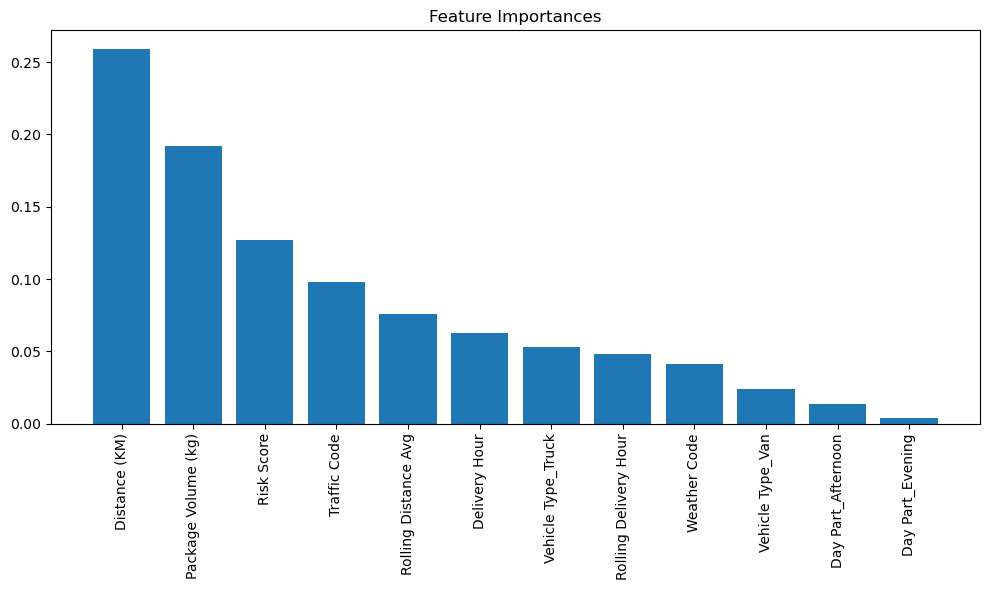

In [93]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [94]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [95]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("📊 Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))

📊 Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



In [96]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("📊 XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

📊 XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



C:\Users\Aayush\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [09:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [97]:
from sklearn.model_selection import GridSearchCV

In [98]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [99]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1'
)

In [100]:
grid_search.fit(X_train, y_train)
print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [101]:
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("📊 Tuned Random Forest Report:\n", classification_report(y_test, y_pred_best_rf))

📊 Tuned Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [102]:
import joblib

In [103]:
# Save the model
joblib.dump(best_rf, "dhl_rf_model.joblib")

['dhl_rf_model.joblib']

In [104]:
# Save the features used for inference
joblib.dump(feature_columns, "feature_columns.pkl")

['feature_columns.pkl']

In [105]:
# app.py
import streamlit as st
import pandas as pd
import joblib

In [106]:
# Load model and features
model = joblib.load("dhl_rf_model.joblib")
features = joblib.load("feature_columns.pkl")

In [107]:
st.title("📦 DHL Delivery Delay Predictor")

2025-06-19 09:10:53.785 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 09:10:54.183 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-19 09:10:54.185 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [108]:
uploaded_file = st.file_uploader("Upload Cleaned Excel File", type=["xlsx"])

2025-06-19 09:11:10.037 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 09:11:10.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 09:11:10.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 09:11:10.041 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-19 09:11:10.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [109]:
if uploaded_file:
    df = pd.read_excel(uploaded_file)
    df.columns = df.columns.str.strip()

    # Assuming 'Delay (Binary)' might be there already — drop if yes
    if "Delay (Binary)" in df.columns:
        df.drop(columns=["Delay (Binary)"], inplace=True)

    # Minimal preprocessing (align features)
    df_processed = df.copy()
    if "Delivery Hour" not in df.columns:
        df_processed["Actual Delivery Time"] = pd.to_datetime(df_processed["Actual Delivery Time"])
        df_processed["Delivery Hour"] = df_processed["Actual Delivery Time"].dt.hour

    # Dummy fill for missing engineered features
    for col in features:
        if col not in df_processed.columns:
            df_processed[col] = 0

    X_input = df_processed[features]
    predictions = model.predict(X_input)

    df["Predicted Delay"] = ["Yes" if p == 1 else "No" for p in predictions]

    st.success("✅ Predictions Completed!")
    st.write(df[["Delivery ID", "Predicted Delay"]])
    st.download_button("Download Predictions as CSV", df.to_csv(index=False), file_name="dhl_predictions.csv")

In [110]:
pip install streamlit openpyxl xgboost joblib scikit-learn pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [111]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)